In [4]:
import sys
import os
sys.path.append("../Classes")



from HomGraph import *
from SFGraph import *
from sighelp import *
from matplotlib.pyplot import cm
from matplotlib.mlab import frange
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import sparse
import scipy as scp
from scipy.sparse import csgraph

import networkx as nx 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



from matplotlib import rcParams


sns.set(context='paper',font_scale = 10,
        rc = {'figure.figsize' : (20,10), 'legend.frameon':True, 
              'legend.loc': 'upper right', "xtick.major.size": 10,"ytick.major.size": 10,
             "xtick.minor.size": 6,"ytick.minor.size": 6, 
              "xtick.major.width": 3, "ytick.major.width": 3,
             "xtick.minor.width": 1, "ytick.minor.width": 1, "lines.linewidth": 14})
# sns.set_style("white")
sns.set_style("ticks")#, {"xtick.major.size": 50, "ytick.major.size": 15, 
#                         "xtick.major.width": 15,"ytick.major.width": 15 })


#Friday July 14

# An exploration of clustering

<p> 1/29/18.. Now we have the task of clustering our frequency responses.  To do this, we should first understand the data.  First, we should visualize the data in two dimensions and see what it looks like!</p> 

__First try to visualize how individual nodes might appear in their time series__

In [5]:
# Check with clustering looks like in two dimension
n = 1000
gam = 1.9
period = 4

my_graph = SFGraph(n, gam) 
# my_graph = HomGraph(50,5)

In [6]:
# my_graph.save_graph("n1000gam19_interesting_downstream")

In [7]:
n = 1000
gam = 1.9
period = 4

prefix = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Clustering/example/"
my_graph = Graph.load_graph(graph_file=prefix+"n1000gam19_interesting_downstream_graph.npy", 
                    state_file=prefix+"n1000gam19_interesting_downstream_state.npy")


In [8]:
out_order = np.flip(np.argsort(my_graph.out_degree()), axis=0)
out_order[2]

877

In [9]:
oscil_node = out_order[0]
my_graph.out_degree()[oscil_node]


994

In [10]:
trials = 5
transient = 1000
t = 2000

arg_srt, dist = get_dist_sort(my_graph, hub_node=oscil_node)


start_config = np.copy(my_graph.get_config())

f, power = avg_spectrum_tbl(graph=my_graph, node_index=oscil_node, 
                            period=period, time=t, trials=trials, 
                            transient_cutoff=transient, normalize=False)




[  0   1 994]


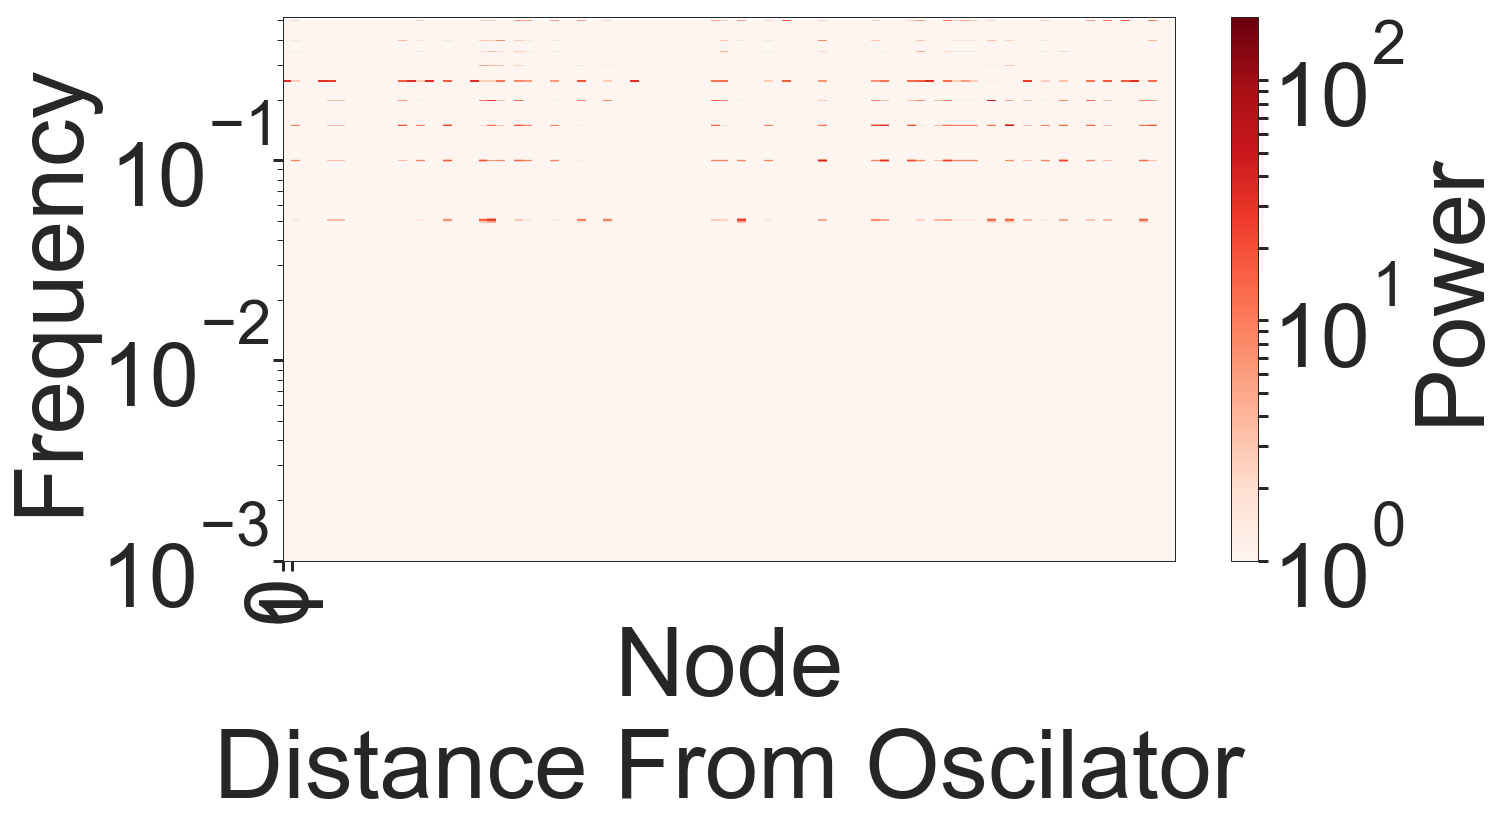

<Figure size 1440x720 with 0 Axes>

In [15]:

title = f"N = {n},$\gamma$={gam},Period={period},time={t}"

# power /= (np.max(power[:, my_graph.find_hub()]))
ax = heatmap_logy(f, (power + 10**-3)[:, arg_srt], low=1,
                  dist_ar=dist, cm=plt.cm.Reds, title="")

a = np.array(ax.get_xticks())
print(ax.get_xticks())
# ax.set_xticks([0,40,69,249,669, 920, 945, 970, 990])
# for i,j in enumerate(np.diff(a)):
#     if j < 15:
#         a[i+1] += 10
plt.xlim([0, 100])
        
# ax.set_xticks(a)
# plt.savefig("/Users/Sam/Desktop/"+ "Cluster Investigation" + title +".png")
ax.set_xlabel("Node\nDistance From Oscilator")
# plt.xlim([0,np.max([np.max(a), n])])
plt.show()
plt.clf()







In [11]:
# Get the actual time series
period = 8
my_graph.set_config(np.copy(start_config))
my_graph.random_config()
tbl = my_graph.oscillate_update(node_index=oscil_node, period=period, time=t)

period2 = 10
my_graph.set_config(np.copy(start_config))
tbl2 = my_graph.oscillate_update(node_index=oscil_node, period=period2, time=t)




In [12]:
Graph.find_attractor_in_oscillations(tbl, period=period), Graph.find_attractor_in_oscillations(tbl2, period=period2)

((32, 56), (20, 30))

In [13]:
# See first couple nodes
arg_srt[0:10]

array([329,   0, 657, 658, 659, 660, 661, 662, 663, 664])

329


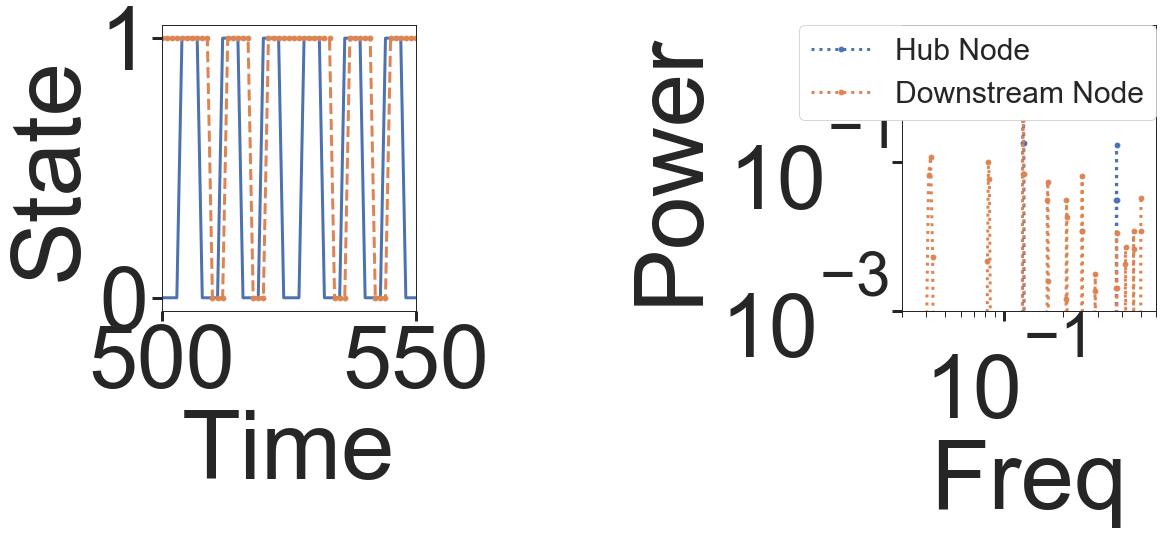

In [14]:
down_node_index = 40
downstream_node = 68#arg_srt[down_node_index]
plt.figure(figsize=(20,10))
ax1 = plt.subplot(121)
print(oscil_node)
plt.plot(tbl[0:650, oscil_node], label="Oscillating Node", linestyle="-",
        linewidth=3)
plt.plot(tbl[0:650, downstream_node], label="Downstream Node", 
         linestyle="--", marker='o', linewidth=3)

# plt.suptitle(f"Varied response by network nodes (Period = {per})\nn={n},$\gamma$={gam}")

plt.xlim([500,550])
plt.xlabel("Time")
plt.ylabel("State")
# plt.title("Hub Node")
# leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
# leg.get_frame().set_alpha(1)

plt.subplot(122)

new_time = t - transient_cutoff
my_window = signal.get_window(window='hamming', Nx = new_time)


f_hub, psd_hub = signal.periodogram(tbl[transient_cutoff:,oscil_node],window=my_window)
f_down, psd_down = signal.periodogram(tbl[transient_cutoff:,downstream_node],window=my_window)


plt.loglog(f_hub, psd_hub / max(psd_hub), linewidth=3,
           label="Hub Node", linestyle=':', marker='o')
plt.loglog(f_down, psd_down / max(psd_hub), linewidth=3 ,
           label="Downstream Node", linestyle=':', marker='o')


leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0, fontsize=30)
leg.get_frame().set_alpha(1)

# plt.title("PSD")
plt.xlabel("Freq")
plt.ylabel("Power")
plt.xlim(0.03, 0.6)
plt.tight_layout()
plt.ylim(10**-3, 7)

#plt.savefig("/Users/Sam/Desktop/VariedNetworkResponse.png")
plt.show()

Separating the plot for time domain..

In [15]:
def get_transition_indices(input_seq): 
    ''' Return list w/ indices where the input sequence switches state'''
    return [True if ((index - 1 > 0) and i != input_seq[index - 1]) else False  for index, i in enumerate(input_seq)]
    

    
    



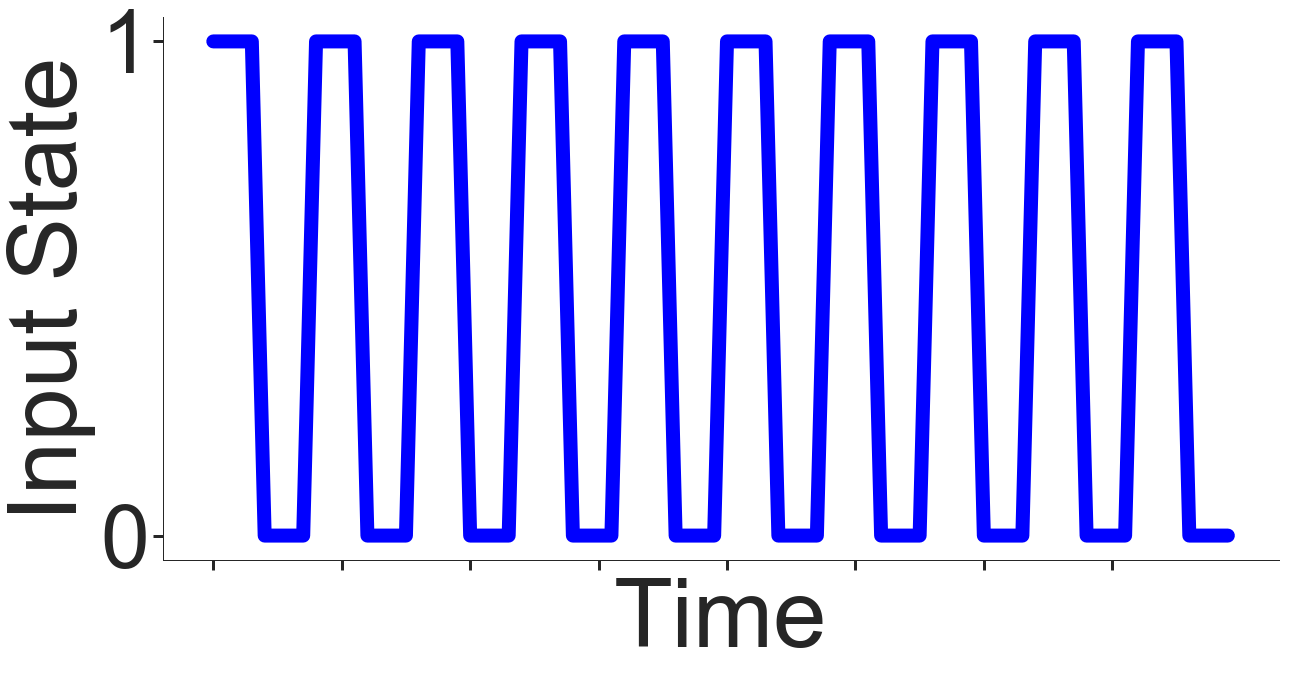

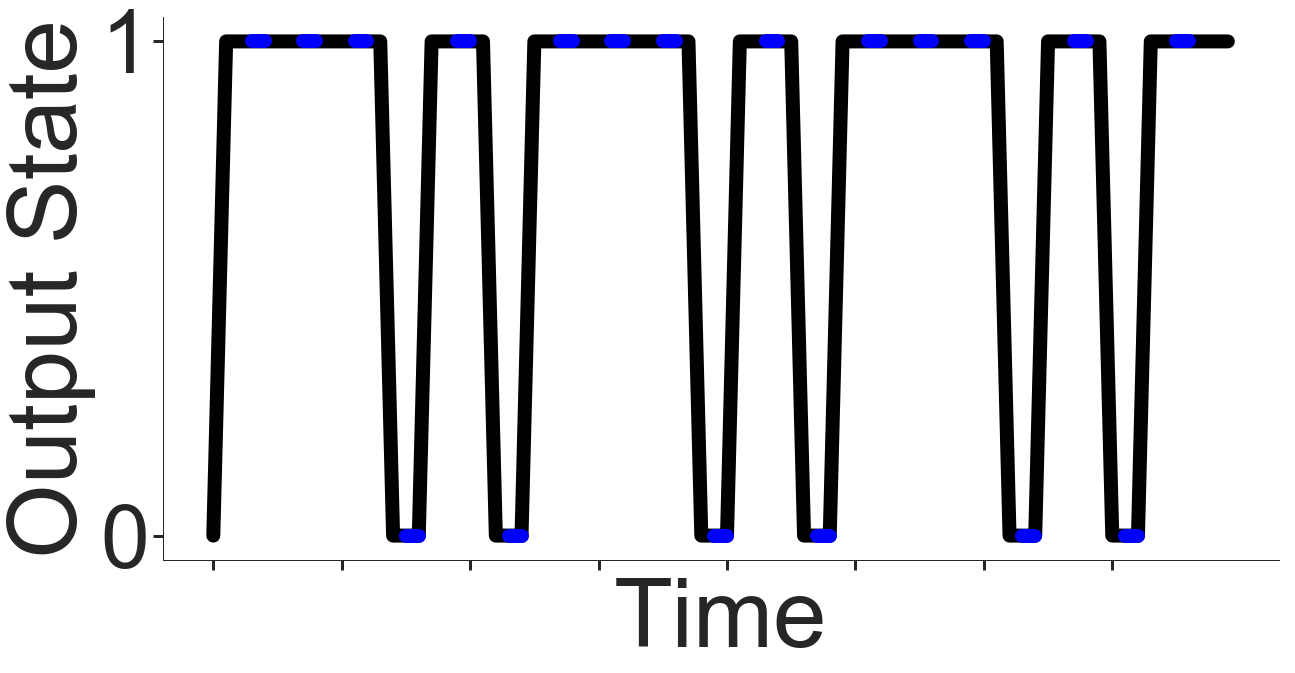

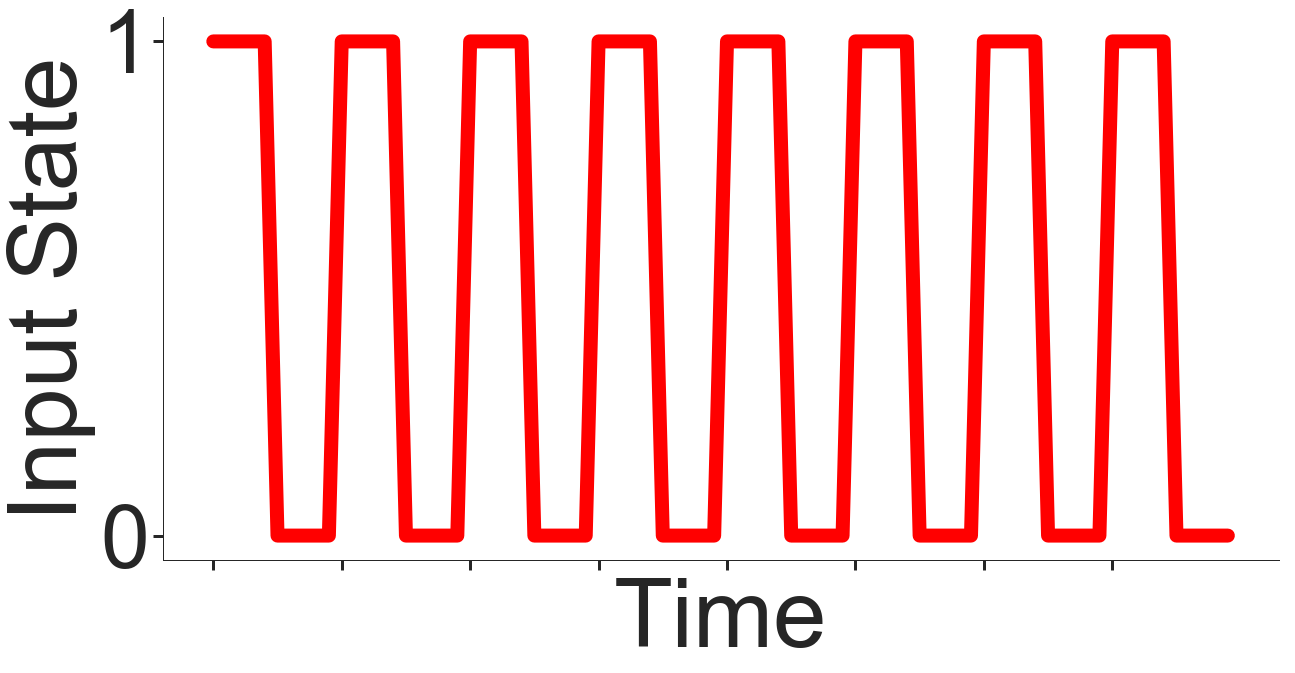

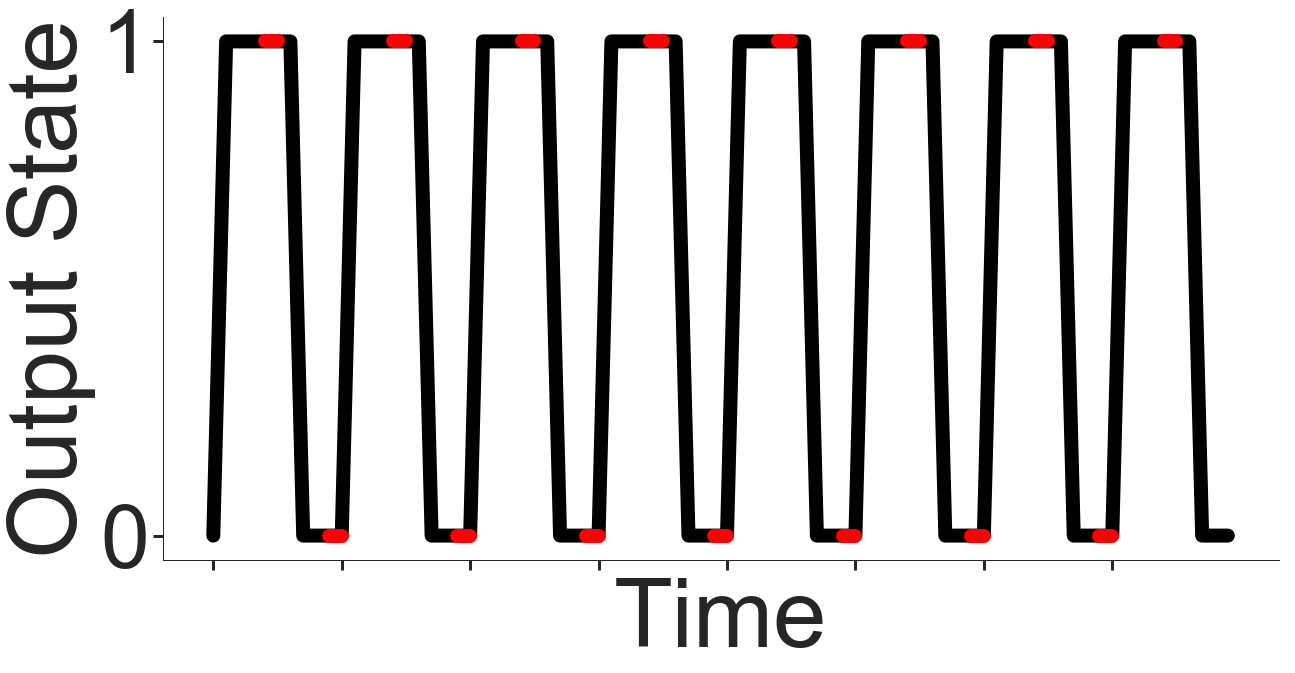

In [18]:

lcm = Graph.get_lcm(per_list=[8,10])
transient_cutoff =  lcm * 10
end_time = lcm * 12

for period_number, (temp_tbl, col)  in enumerate(zip([tbl, tbl2], ['blue', 'red'])):

    test_seq = get_transition_indices(temp_tbl[transient_cutoff:end_time, oscil_node])
    plt.plot(temp_tbl[transient_cutoff:end_time, oscil_node], c=col)

    plt.xlabel("Time")
    plt.ylabel("Input State")
    plt.yticks([0,1], [0,1])
    plt.xticks(np.arange(transient_cutoff, end_time, 10) - transient_cutoff, [])


    sns.despine()
    plt.savefig(f"/Users/Sam/Desktop/upstream{period_number}.pdf")
    plt.show()




    plt.plot(temp_tbl[transient_cutoff:end_time, downstream_node], c="black")

    input_seq = temp_tbl[transient_cutoff:end_time, downstream_node]
    for index, i in enumerate(test_seq): 
        if i: 
            plt.plot([index - 1, index], input_seq[index -1: index+1], c=col)



    plt.xlabel("Time")
    plt.ylabel("Output State")
    plt.yticks([0,1], [0,1])
    plt.xticks(np.arange(transient_cutoff, end_time, 10) - transient_cutoff, [])


    sns.despine()
    plt.savefig(f"/Users/Sam/Desktop/downstream{period_number}.pdf")
    plt.show()




In [135]:
period

8

Separating the plot...

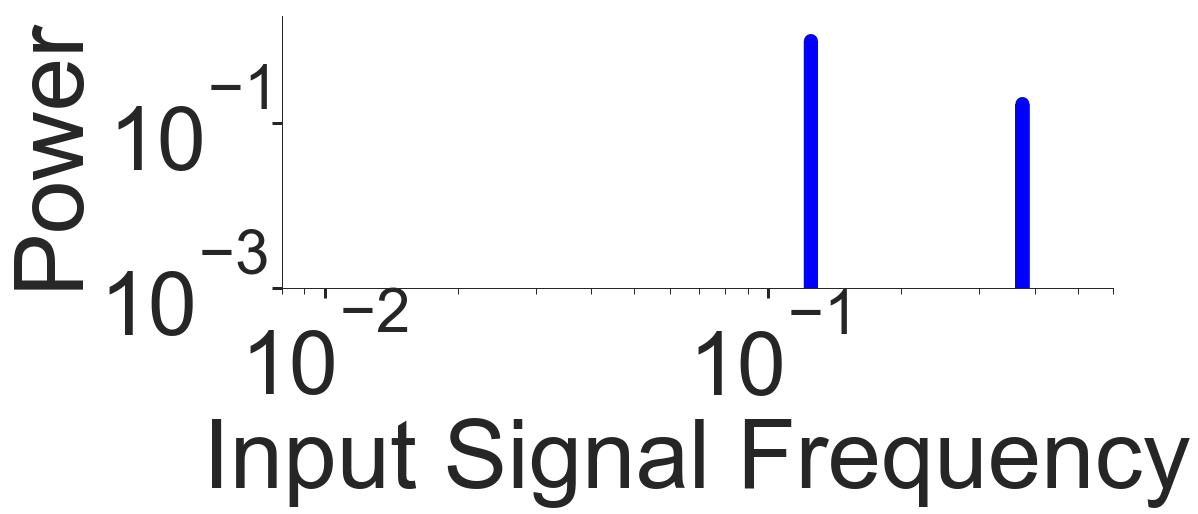

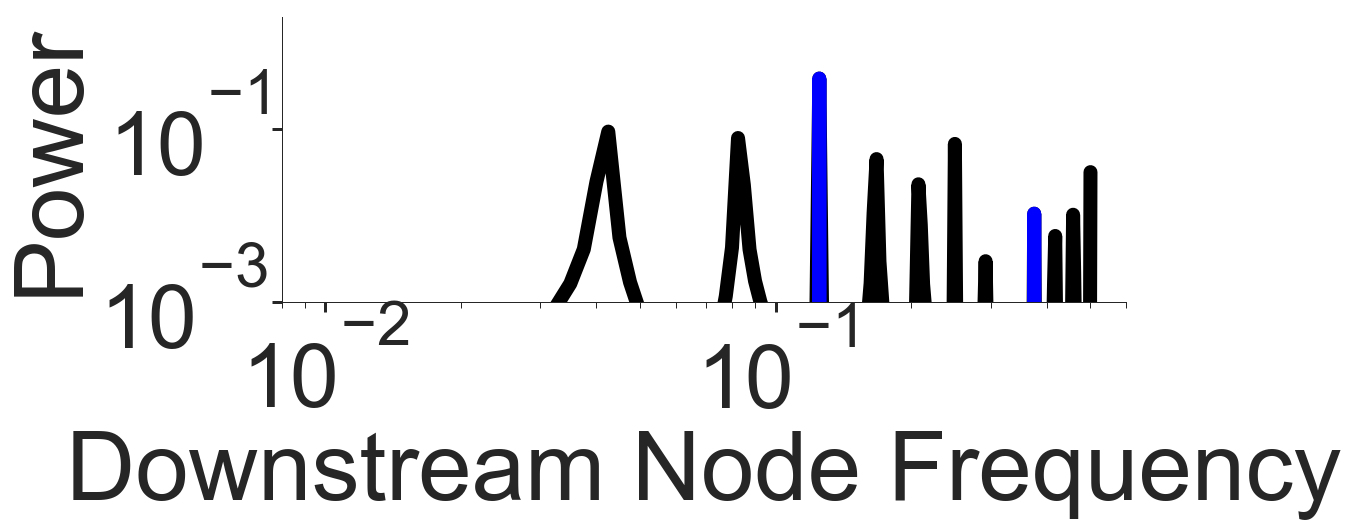

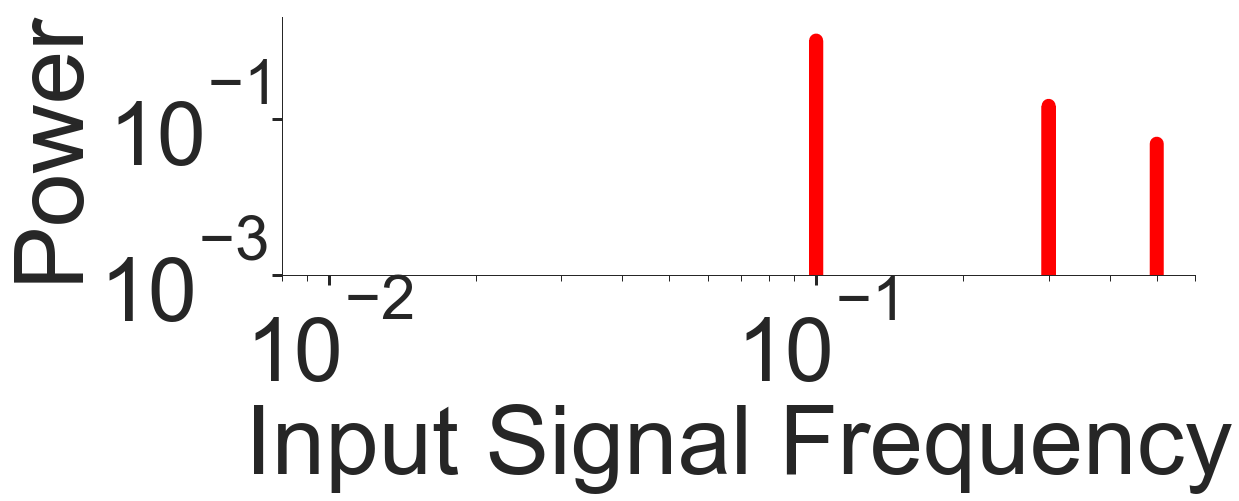

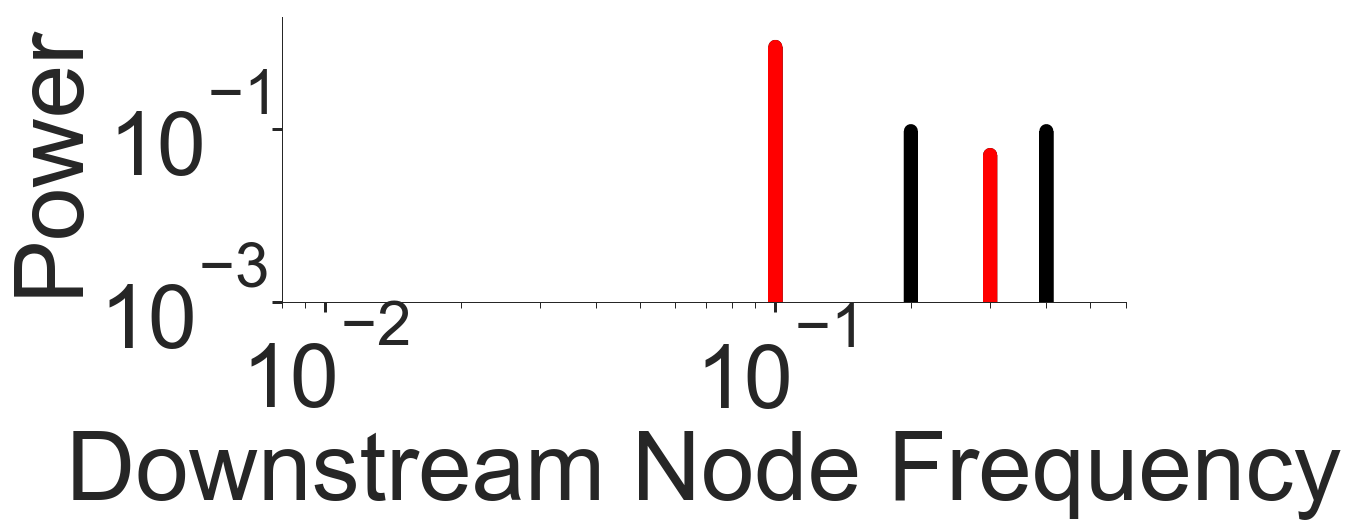

In [22]:
# down_node_index = 40
# downstream_node = arg_srt[down_node_index]
# plt.plot(tbl[0:650, oscil_node], label="Oscillating Node", linestyle="-",
#         linewidth=3)
# plt.plot(tbl[0:650, downstream_node], label="Downstream Node", 
#          linestyle="--", marker='o', linewidth=3)

# plt.suptitle(f"Varied response by network nodes (Period = {per})\nn={n},$\gamma$={gam}")

# plt.xlim([500,550])
# plt.xlabel("Time")
# plt.ylabel("State")
# plt.title("Hub Node")
# leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
# leg.get_frame().set_alpha(1)

# plt.subplot(122)
lcm = Graph.get_lcm(per_list=[period,period2])
transient_cutoff =  lcm * 10
end_time = lcm * 20
new_time = t - transient_cutoff
my_window = None #signal.get_window(window='hamming', Nx = new_time)
show_resonance=False



f_hub, psd_hub = signal.periodogram(tbl[transient_cutoff:end_time,oscil_node],window=my_window)
f_down, psd_down = signal.periodogram(tbl[transient_cutoff:end_time,downstream_node],window=my_window)
f_hub_2, psd_hub_2 = signal.periodogram(tbl2[transient_cutoff:end_time,oscil_node],window=my_window)
f_down_2, psd_down_2 = signal.periodogram(tbl2[transient_cutoff:end_time,downstream_node],window=my_window)

# Normalizing factors...
max_val_1 = np.max(signal.periodogram(x=tbl[transient_cutoff:end_time, ].T)[1])
max_val_2 = np.max(signal.periodogram(x=tbl2[transient_cutoff:end_time, ].T)[1])

plt.loglog(f_hub, psd_hub / max_val_1,
           label="Input $T_1=4$", linestyle='-', marker='o', c="blue")

# plt.loglog(f_hub_2, psd_hub_2 / max(psd_hub_2), linewidth=3,
#            label="Input $T_2=14$", linestyle='-', marker='o', c="black")



# leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
# leg.get_frame().set_alpha(1)

# plt.title("PSD")
plt.xlabel("Input Signal Frequency")
plt.ylabel("Power")
plt.xlim(0.008, 0.6)
plt.tight_layout()
plt.ylim(10**-3, 2)
sns.despine()


plt.savefig("/Users/Sam/Desktop/VariedNetworkResponse1.pdf", bbox_inches='tight')

plt.show()

temp_mask = psd_hub < 0.001
psd_down_copy = np.copy(psd_down)
psd_down_copy[temp_mask] = 0

plt.loglog(f_down, psd_down / max_val_1,
           label="Input Period $T_1=4$", linestyle='-', marker='o', c="black")

plt.loglog(f_down, (psd_down_copy / max_val_1) ,
           label="Input Period $T_1=4$", linestyle='-', marker='o', c="blue")

# Plot resonances
if show_resonance: 
    for i in range(2,2): 
        plt.loglog(f_down * i, (psd_down_copy / max(psd_hub)) ,
                   label="resonance_freqs", linestyle=':', marker='o', c="orange")






# plt.loglog(f_down_2, psd_down_2 / max(psd_hub_2), linewidth=3 ,
#            label=f"Input Period $T_2=14$", linestyle='-', marker='o', c="black")



# leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
# leg.get_frame().set_alpha(1)

# plt.title("PSD")
plt.xlabel("Downstream Node Frequency")
plt.ylabel("Power")
plt.xlim(0.008, 0.6)
# ax = plt.gca()
# ax.set_xticks(ax.get_xticks()[::2])
plt.tight_layout()
plt.ylim(10**-3, 2)
ax = plt.gca()
sns.despine()



plt.savefig("/Users/Sam/Desktop/VariedNetworkResponse2.pdf", bbox_inches='tight')

plt.show()


########### Second input frequency...

# Input node

# plt.loglog(f_hub, psd_hub / max(psd_hub), linewidth=3,
#            label="Input $T_1=4$", linestyle='-', marker='o', c="black")



plt.loglog(f_hub_2, psd_hub_2 / max_val_2,
           label="Input $T_2=14$", linestyle='-', marker='o', c="red")



# leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
# leg.get_frame().set_alpha(1)

# plt.title("PSD")
plt.xlabel("Input Signal Frequency")
plt.ylabel("Power")
plt.xlim(0.008, 0.6)
plt.tight_layout()
plt.ylim(10**-3, 2)
sns.despine()
plt.savefig("/Users/Sam/Desktop/VariedNetworkResponse3.pdf", bbox_inches='tight')

plt.show()

## Output node.. 


temp_mask = psd_hub_2 < 0.001
psd_down_copy = np.copy(psd_down_2)
psd_down_copy[temp_mask] = 0



# plt.loglog(f_down, psd_down / max(psd_hub), linewidth=3 ,
#            label="Input Period $T_1=4$", linestyle='-', marker='o', c="black")
plt.loglog(f_down_2, psd_down_2 / max_val_2,
           label=f"Input Period $T_2=14$", linestyle='-', marker='o', c="black")
plt.loglog(f_down_2, psd_down_copy / max_val_2 ,
           label=f"Input Period $T_2=14$", linestyle='-', marker='o', c="red")


if show_resonance: 
    for i in range(2,6): 
        plt.loglog(f_down_2 * i, (psd_down_copy / max_val_2) ,
                   label="resonance_freqs", linestyle=':', marker='o', c="orange")


# leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
# leg.get_frame().set_alpha(1)

# plt.title("PSD")
plt.xlabel("Downstream Node Frequency")
plt.ylabel("Power")
plt.xlim(0.008, 0.6)
plt.tight_layout()
plt.ylim(10**-3, 2)
sns.despine()


plt.savefig("/Users/Sam/Desktop/VariedNetworkResponse4.pdf", bbox_inches='tight')
plt.show()




In [36]:
# Trying to analyze multiplicity 
f_hub[psd_down> 0.001], f_hub[psd_hub> 0.001]

(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 array([0.25]))

In [41]:
f_hub[psd_down_2 > 0.001] , f_hub[psd_hub_2 > 0.001]

(array([0.07142857, 0.14285714, 0.21428571, 0.28571429, 0.35714286,
        0.42857143]), array([0.07142857, 0.21428571, 0.35714286, 0.5       ]))

In [32]:
## If we want to view the spectrogram
# f, t, Sxx = signal.spectrogram(tbl[:,arg_srt[18]])
# plt.pcolormesh(t, f, Sxx)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

__Can we plot this reactive node under different hub oscillations?__

In [276]:
# Get the actual time series
my_graph.random_config()
start_config = my_graph.get_config()
my_graph.set_config(np.copy(start_config))
tbl1 = my_graph.oscillate_update(node_index=oscil_node, period=4, time=t)
my_graph.set_config(np.copy(start_config))
tbl2 = my_graph.oscillate_update(node_index=oscil_node, period=14, time=t)

my_graph.set_config(np.copy(start_config))
tbl3 = my_graph.oscillate_update(node_index=oscil_node, period=20, time=t)

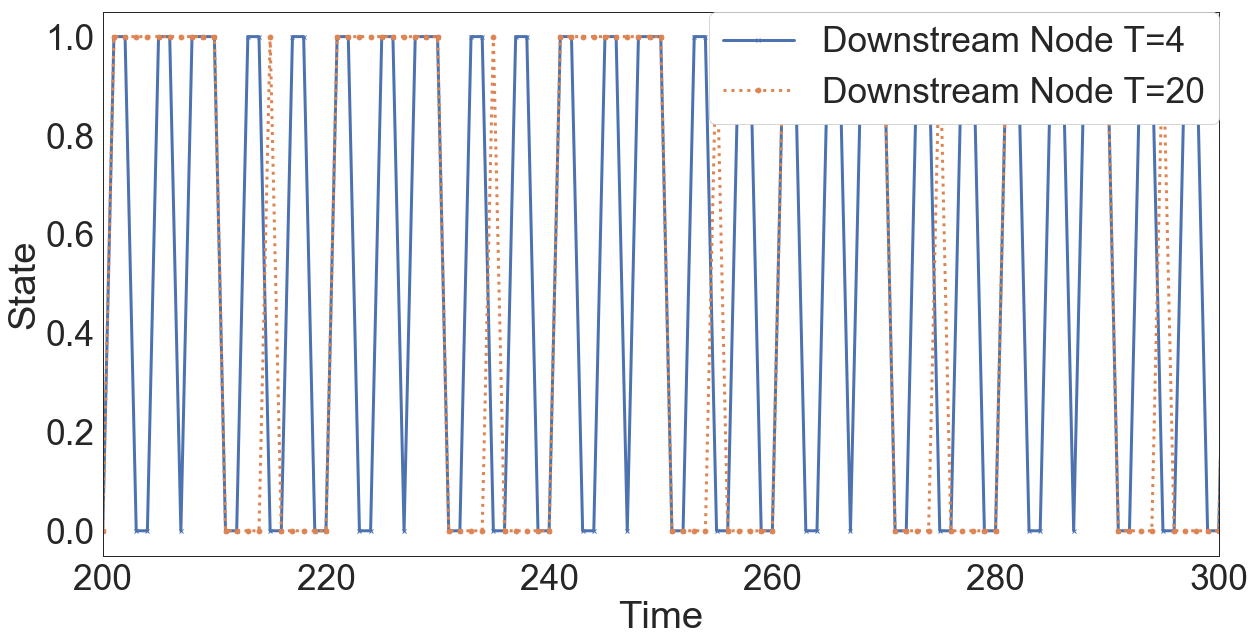

In [284]:
downstream_node = arg_srt[down_node_index]

plt.figure(figsize=(20,10))
plt.plot(tbl1[0:600, downstream_node], label="Downstream Node T=4", linewidth=3,
         linestyle="-", marker="x")
# plt.plot(tbl2[400:600, downstream_node], label="Downstream Node T=14", linestyle="--")
plt.plot(tbl3[0:600, downstream_node], label="Downstream Node T=20", linewidth=3,
         linestyle=":", marker="o")

plt.xlim([200,300])
plt.xlabel("Time")
plt.ylabel("State")
# plt.title("Hub Node")
leg = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
leg.get_frame().set_alpha(1)
plt.show()

## Statistics for downstream response...

In [50]:
from scipy.fftpack import fft

In [164]:
n = 1000
gammas = [1.7, 1.9, 2.2, 2.5, 3.0] 
period = 10
time = 2000
transient = 1000
trials = 10 

rets = {gam:[] for gam in gammas}
for gam in gammas: 
    for _ in range(trials): 
        my_graph = SFGraph(n, gam)
        hub = my_graph.find_hub()
        tbl = my_graph.oscillate_update(hub, period=period, force_start_on=False, time=time)
        hub_seq = tbl[transient:, hub]
        # Control attempt... Try to take this w.r.t. another element..
#         tbl = my_graph.update_return_table(time)
        # hub_fft = fft(hub_seq)
        # max_signal = np.dot(hub_fft, hub_fft)
        max_signal = np.dot(signal.periodogram(hub_seq)[1], signal.periodogram(hub_seq)[1])
        for index in range(n): 
            seq = tbl[transient:, index]
            #dot_prod = (np.dot(np.abs(fft(seq)), np.abs(hub_fft))) / max_signal
            dot_prod = (np.dot(signal.periodogram(seq)[1], signal.periodogram(hub_seq)[1])) / max_signal

        #     if dot_prod == 0:
        #         mem_seq = seq

            rets[gam].append(dot_prod)
        


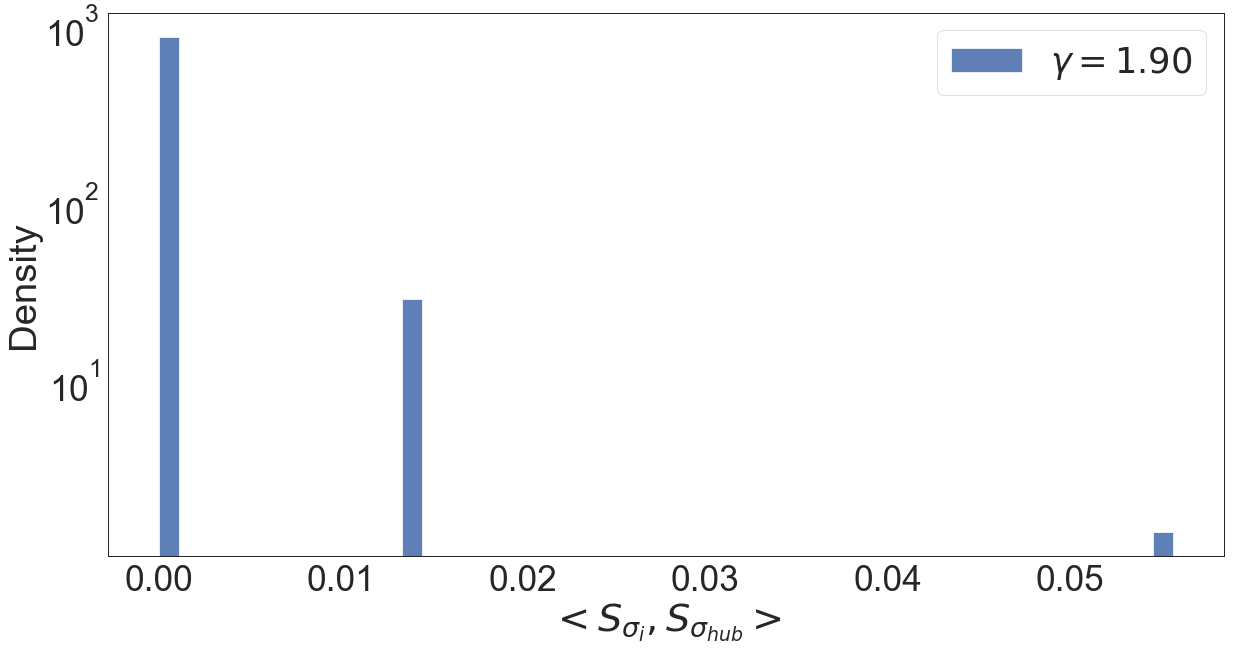

In [163]:
for gam in gammas:
    plt.hist(rets[gam], density=True, bins=50, label=f"$\gamma={gam:.2f}$", alpha=0.9)
plt.xlabel("$<S_{\sigma_i},S_{\sigma_{hub}}>$")
plt.ylabel("Density")
plt.legend()
plt.yscale('log')
plt.show()

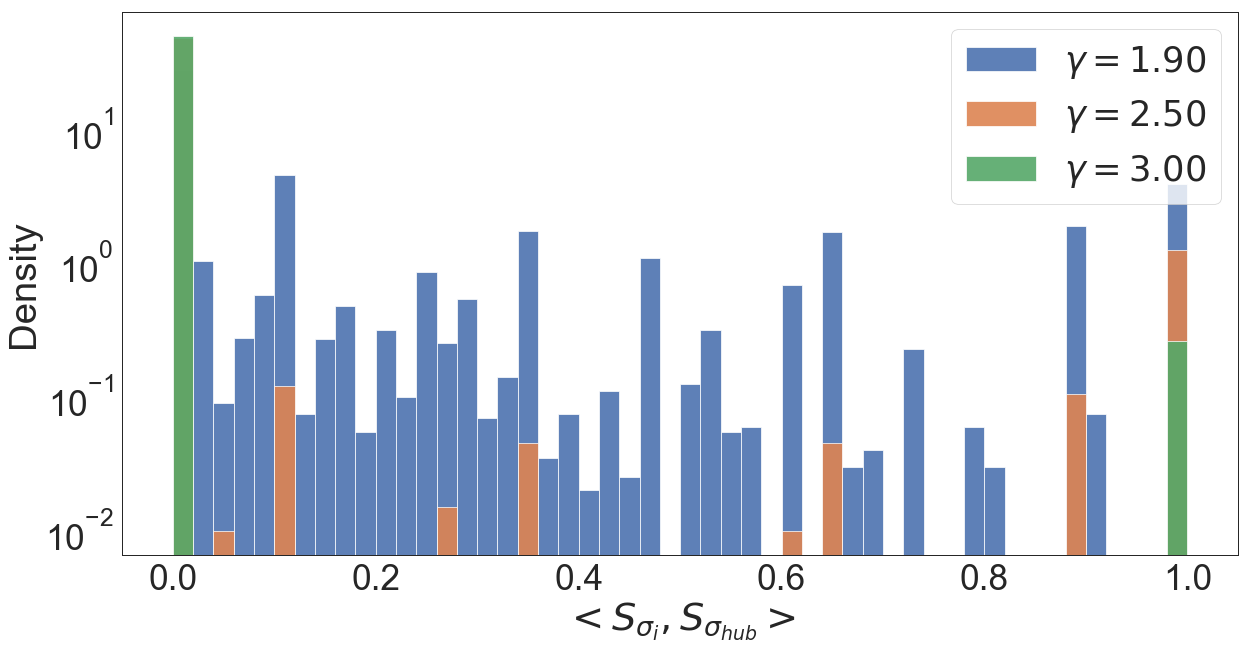

In [165]:
for gam in gammas[1::2]+[3.0]:
    plt.hist(rets[gam], density=True, bins=50, label=f"$\gamma={gam:.2f}$", alpha=0.9)
plt.xlabel("$<S_{\sigma_i},S_{\sigma_{hub}}>$")
plt.ylabel("Density")
plt.legend()
plt.yscale('log')
plt.show()

__Now that we can see individual time series of the nodes, can we cluster them?__

In [288]:
def cluster_and_vis(power, n_clusters = 5): 
    pca = PCA()
    pca_result = pca.fit_transform(power.T)
    kmeans = KMeans(n_clusters= n_clusters, random_state=0)
    kmeans = kmeans.fit(power.T)

#     kmeans_argsrt = np.argsort(kmeans.labels_) 
#     kmeans_label_sort = kmeans.labels_[kmeans_argsrt]
    num_colors = np.max(kmeans.labels_) - np.min(kmeans.labels_) + 1
    colors=plt.cm.rainbow(np.linspace(0,1, num_colors))
    for index, col in enumerate(colors): 
        ## Enumerate colors
        truth_ar = (kmeans.labels_ == index)
        plt.scatter(pca_result[truth_ar, 0], pca_result[truth_ar, 1], c=col, label =index,  s=50)
    plt.xlabel("Pca-One")
    plt.ylabel("Pca-Two")
    plt.title("PCA of power signals")

#     for i, txt in enumerate(kmeans.labels_):
#         plt.annotate(txt, (pca_result[i,0], pca_result[i,1]))

    plt.legend()
    plt.show()
    return kmeans

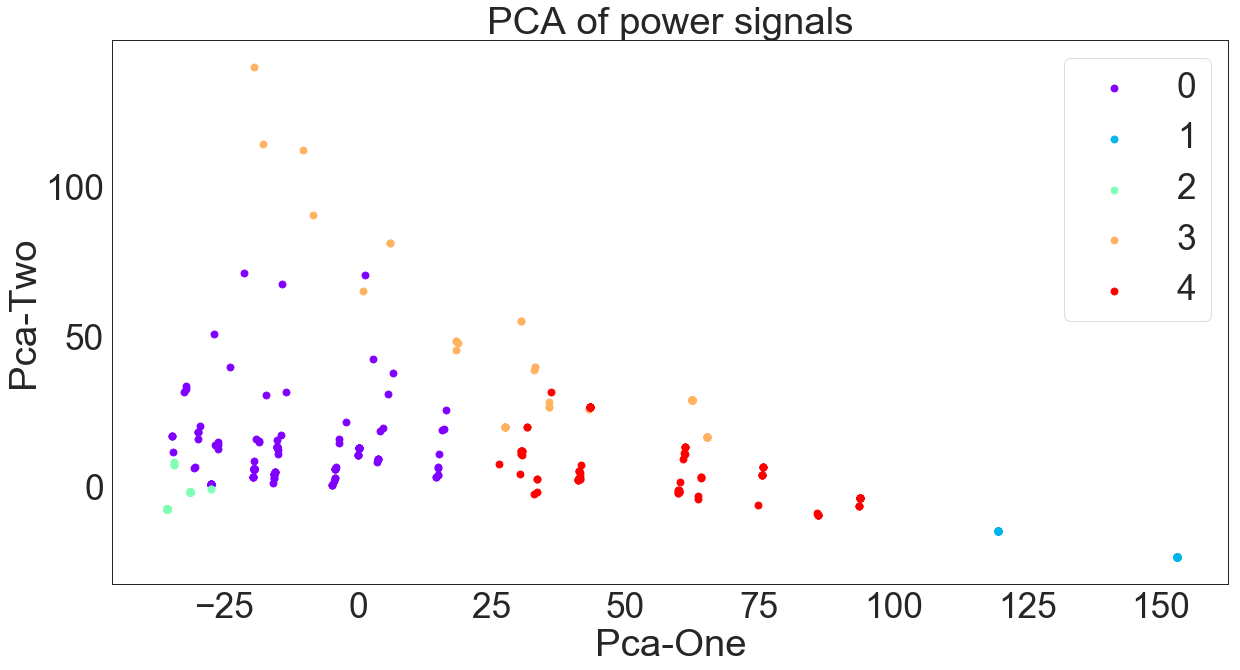

In [292]:
kmeans = cluster_and_vis(power, n_clusters=5)

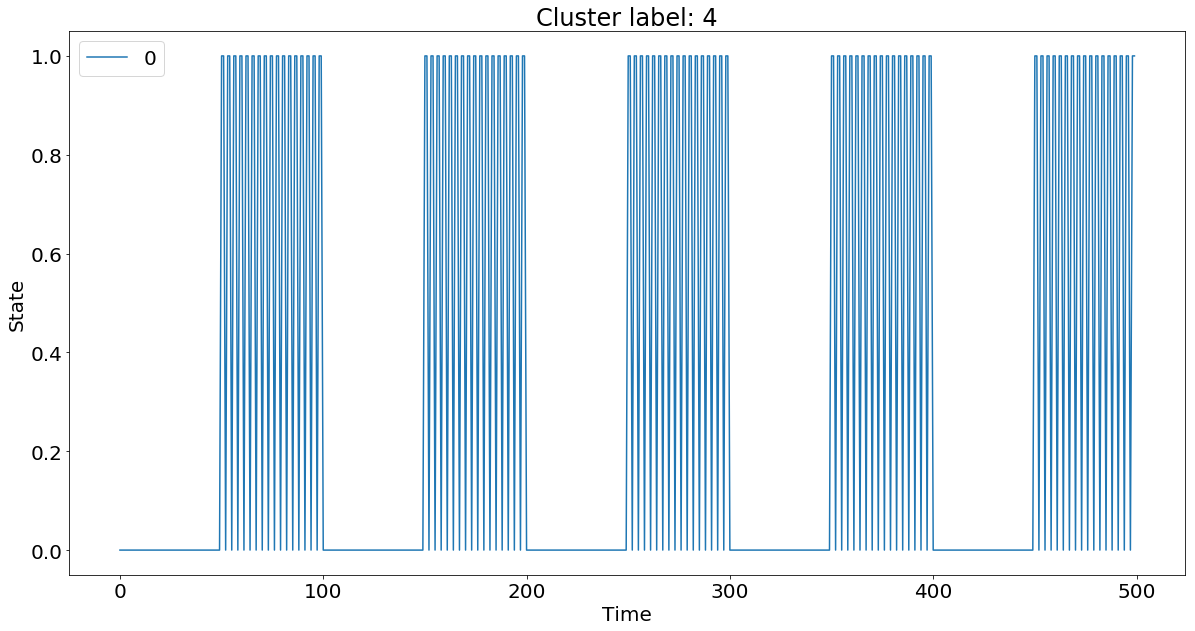

In [145]:
kmean_label = 4
trials = 1

tbl_subset = tbl[2000:, kmeans.labels_ == kmean_label]

tbl_times, tbl_nodes = tbl_subset.shape
for i in range(trials): 
    plt.plot(tbl_subset[0:500, np.random.randint(0, tbl_nodes)], label=i)



plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.title(f"Cluster label: {kmean_label}")
plt.show()



# 2/1/18 How does normalization affect the clusters we get?
<p> For a network, take two trials with the same initial conditions, where one is normalized, the other isnt.  How does this affect PCA / clusters?</p>

In [9]:
# Create network and given period
n = 1000 
gam = 2.0
period = 100
my_graph = SFGraph(n, gam) 

In [10]:
trials = 3
transient = 2000
t = 5000
arg_srt, dist = get_dist_sort(my_graph)
my_graph.random_config()
start_config = np.copy(my_graph.get_config())




In [11]:
# Normalization parameters... 
# Ignore division, since this is only good for visualization! Shouldn't affect clusters... 


# Reset network state
my_graph.set_config(np.copy(start_config))
f, power = avg_spectrum_tbl(graph=my_graph, node_index=my_graph.find_hub(), period=period, time=t, trials=trials, transient_cutoff=transient, normalize=False)


# get power with normalization
my_graph.set_config(np.copy(start_config))
f, power_normalize = avg_spectrum_tbl(graph=my_graph, node_index=my_graph.find_hub(), period=period, time=t, trials=trials, transient_cutoff=transient, normalize=True)

# Get the actual time series
my_graph.set_config(np.copy(start_config))
tbl = my_graph.oscillate_update(node_index=my_graph.find_hub(), period=period, time=t)

In [40]:
# PCA Breakdown 

pca = PCA(n_components=3)
pca_result = pca.fit_transform(power.T)

pca_norm = PCA(n_components=3)
pca_result_norm = pca.fit_transform(power_normalize.T)




In [41]:
clusters = 7 
kmeans = KMeans(n_clusters= 7, random_state=0)
kmeans = kmeans.fit(power.T)

kmeans_norm = KMeans(n_clusters= 7, random_state=0)
kmeans_norm = kmeans_norm.fit(power_normalize.T)

In [58]:
### Trying to see the difference between clustering... cl

print(kmeans_norm.labels_[19])
print(kmeans.labels_[19])


print(np.where(kmeans_norm.labels_ == 2))
print(np.where(kmeans.labels_ == 5))

0
1
(array([  3,  14,  22,  38,  59,  65, 126, 137, 139, 142, 146, 158, 174,
       177, 194, 247, 250, 269, 290, 302, 310, 318, 321, 334, 341, 353,
       357, 376, 396, 406, 414, 425, 435, 448, 454, 475, 499, 517, 547,
       552, 567, 577, 581, 586, 596, 601, 627, 631, 644, 645, 662, 664,
       669, 679, 694, 720, 734, 766, 797, 805, 830, 832, 834, 839, 841,
       861, 867, 873, 878, 888, 896, 897, 967, 992, 995]),)
(array([  3,  14,  22,  59,  65, 126, 137, 139, 142, 146, 158, 174, 177,
       194, 247, 250, 269, 290, 302, 310, 318, 321, 334, 341, 353, 357,
       376, 396, 406, 414, 425, 435, 448, 454, 475, 499, 517, 547, 552,
       567, 577, 581, 586, 596, 601, 627, 631, 644, 645, 662, 664, 669,
       679, 694, 720, 734, 766, 797, 805, 830, 832, 834, 839, 841, 861,
       867, 873, 878, 888, 896, 897, 967, 992, 995]),)


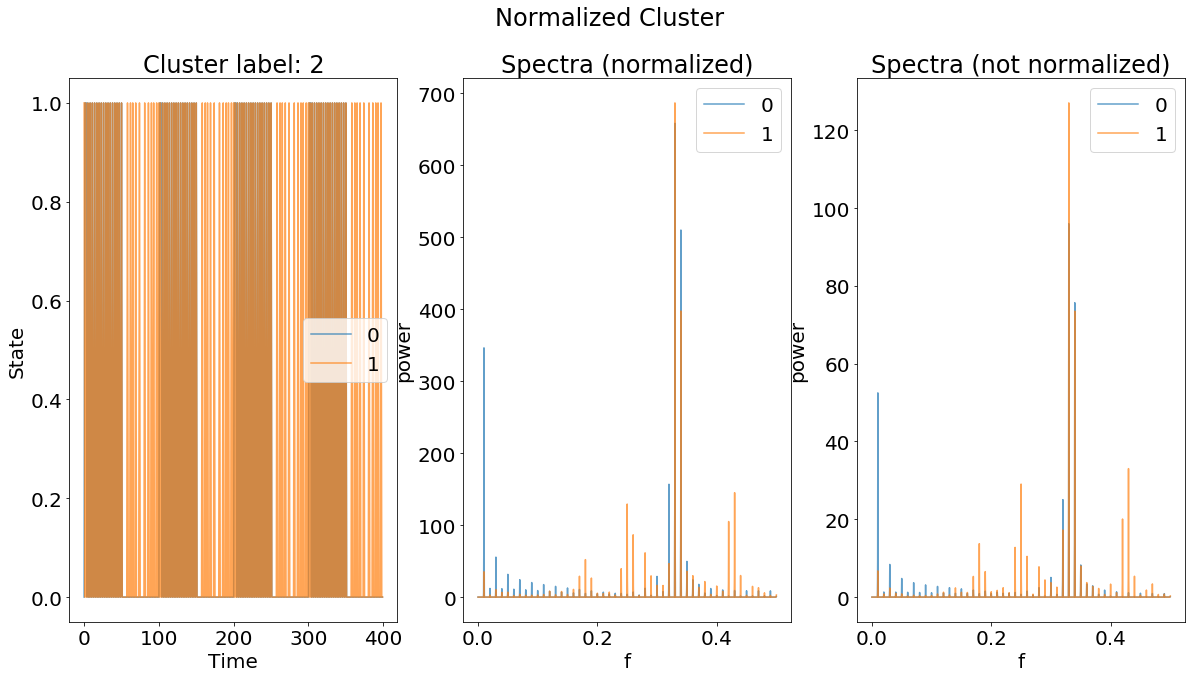

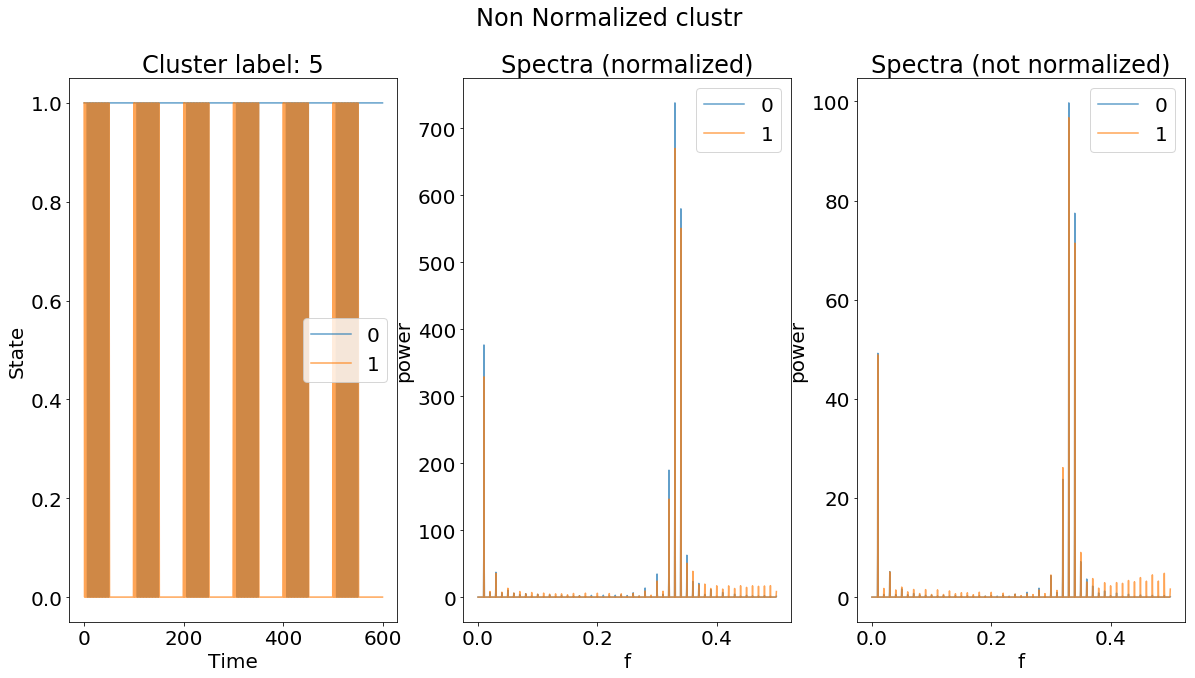

In [66]:
trials = 2

# Normalized clusters



kmean_label = 2

tbl_subset = tbl[2000:, kmeans_norm.labels_ == kmean_label]
power_subset = power[:, kmeans_norm.labels_ == kmean_label]
power_normalize_subset = power_normalize[:, kmeans_norm.labels_ == kmean_label]



tbl_times, tbl_nodes = tbl_subset.shape


fig, ax = plt.subplots(1,3)

for i in range(trials): 
    ### ERROR: tblsubset is not the same as power_nor
    rnd_node = np.random.randint(0, tbl_nodes)
    plt.sca(ax[0])
    plt.plot(tbl_subset[0:400, rnd_node], label=i, alpha=0.7)
    plt.sca(ax[1])
    plt.plot(f, power_normalize_subset[:, rnd_node], label=i, alpha=0.7)
    plt.sca(ax[2])
    plt.plot(f, power_subset[:, rnd_node], label=i, alpha=0.7)

plt.sca(ax[0])
plt.title(f"Cluster label: {kmean_label}")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()

plt.sca(ax[1])
plt.title(f"Spectra (normalized)")
plt.xlabel('f')
plt.ylabel("power")
plt.legend()

plt.sca(ax[2])
plt.title(f"Spectra (not normalized)")
plt.xlabel('f')
plt.ylabel("power")
plt.legend()
plt.suptitle("Normalized Cluster")
plt.show()


# Non normalized clusters


kmean_label = 5

tbl_subset = tbl[2000:, kmeans.labels_ == kmean_label]
power_subset = power[:, kmeans.labels_ == kmean_label]
power_normalize_subset = power_normalize[:, kmeans.labels_ == kmean_label]



tbl_times, tbl_nodes = tbl_subset.shape


fig, ax = plt.subplots(1,3)

for i in range(trials): 
    ### ERROR: tblsubset is not the same as power_nor
    rnd_node = np.random.randint(0, tbl_nodes)
    plt.sca(ax[0])
    plt.plot(tbl_subset[0:600, rnd_node], label=i, alpha=0.7)
    plt.sca(ax[1])
    plt.plot(f, power_normalize_subset[:, rnd_node], label=i, alpha=0.7)
    plt.sca(ax[2])
    plt.plot(f, power_subset[:, rnd_node], label=i, alpha=0.7)

plt.sca(ax[0])
plt.title(f"Cluster label: {kmean_label}")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()

plt.sca(ax[1])
plt.title(f"Spectra (normalized)")
plt.xlabel('f')
plt.ylabel("power")
plt.legend()

plt.sca(ax[2])
plt.title(f"Spectra (not normalized)")
plt.xlabel('f')
plt.ylabel("power")
plt.legend()
plt.suptitle("Non Normalized clustr")

plt.show()





## Can we try to cluster many different networks responding together? 

In [88]:
def get_node_spectra(my_graph, period, t=5000, trials=4, transient=2000): 
    '''
        Return a 2d array with the power spectra of each node respondign to the hub being oscillated at period
        Normalize fals!
    '''
    
    f, power = avg_spectrum_tbl(graph=my_graph, node_index=my_graph.find_hub(), period=period, time=t, trials=trials, transient_cutoff=transient, normalize=False)
    power /= (np.max(power[:, my_graph.find_hub()]))
    
    return f, power


    
def stack_power(n, gam, trials, period): 
    '''
        concatenate many node spectras together... 
    '''
    
    graphs = []
    powers = []
    for _ in range(trials): 
        print(_)
        test_graph = SFGraph(n, gam)
        f, power = get_node_spectra(test_graph, period)
        graphs.append(test_graph)
        powers.append(power)
    return f, np.hstack(powers)
    
    

f, stacked_pow = stack_power(1000, 2.0, 5, 100)

0
1
2
3
4


In [ ]:
##### Cluster these and visualize!!

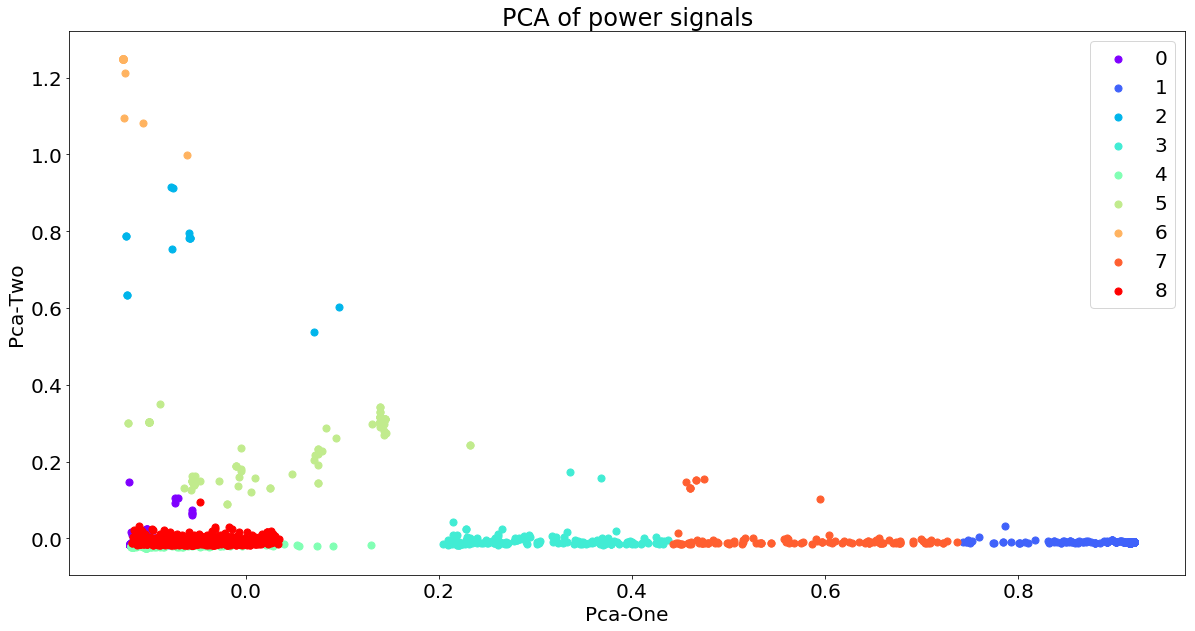

In [120]:
cluster_and_vis(stacked_pow, n_clusters=10)

## Control Oscillation Network to compare this to 

In [ ]:
my_graph = SFGraph(n, 1.8)
my_graph.random_config()
start = np.copy(my_graph.get_config())
f, power = avg_spectrum_tbl_ctrl(graph=my_graph, normalize=False, time=2000, transient_cutoff=1000, trials=1)
my_graph.set_config(start)
tbl = my_graph.update_return_table(time=2000)
Graph.find_attractor(tbl)

heatmap_logy(f, (power + 10 ** -3), low = 1, title="")
plt.show()

cluster_and_vis(power, n_clusters=3)

# 2/2/18 Quick sanity check on variance... 

For normalization, namely considering frozen nodes, what does the best metric of "oscillators" look like?

<b> Conclusion: There is a tradeoff between capturing pulses and picking up random signals... As the variance decreases (more asymmetric signals), we become more likely to miss the signal without normalization.  With normalization, we become more likely to accidentally capture random noise.. Hmmm...</b>

In [79]:
# For totally random sequence, var approaches 0.25

rnd_seq = np.random.randint(0,2, 10000)
np.var(rnd_seq)


0.24995644000000003

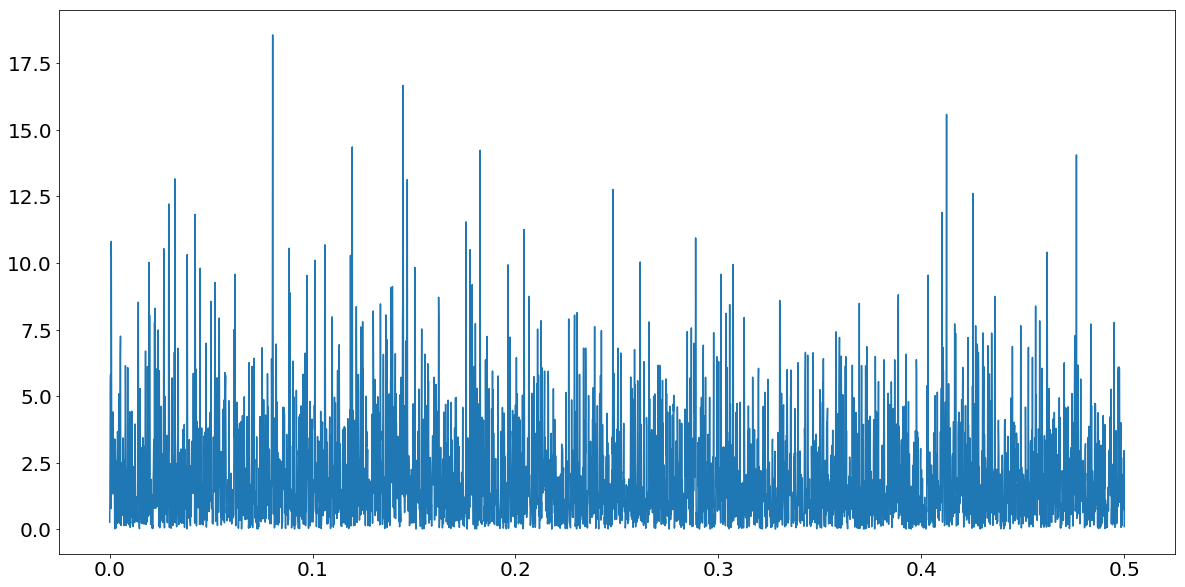

In [80]:
f, psd = get_psd_table(table=rnd_seq.reshape(10000, 1), transient_cutoff=1000, normalize=True)
plt.plot(f, psd)
plt.show()

In [42]:
# For calculating integral.. 
np.repeat(np.diff(f)[0], repeats=psd.size)

# Integrates to 1!! 
np.dot(psd.T, np.repeat(np.diff(f)[0], repeats=psd.size))

array([0.99985803])

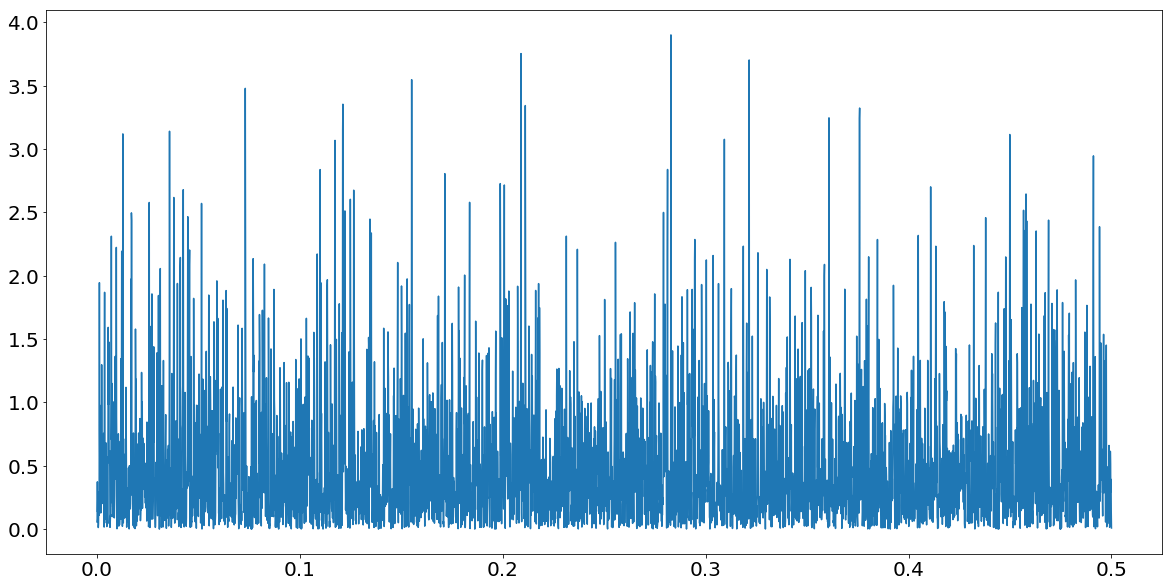

In [64]:
f, psd = get_psd_table(table=rnd_seq.reshape(10000, 1), transient_cutoff=1000, normalize=False)
plt.plot(f, psd)
plt.show()

In [46]:
# For calculating integral.. 
np.repeat(np.diff(f)[0], repeats=psd.size)

# Integrates to var... 
np.dot(psd.T, np.repeat(np.diff(f)[0], repeats=psd.size))

array([0.24992717])

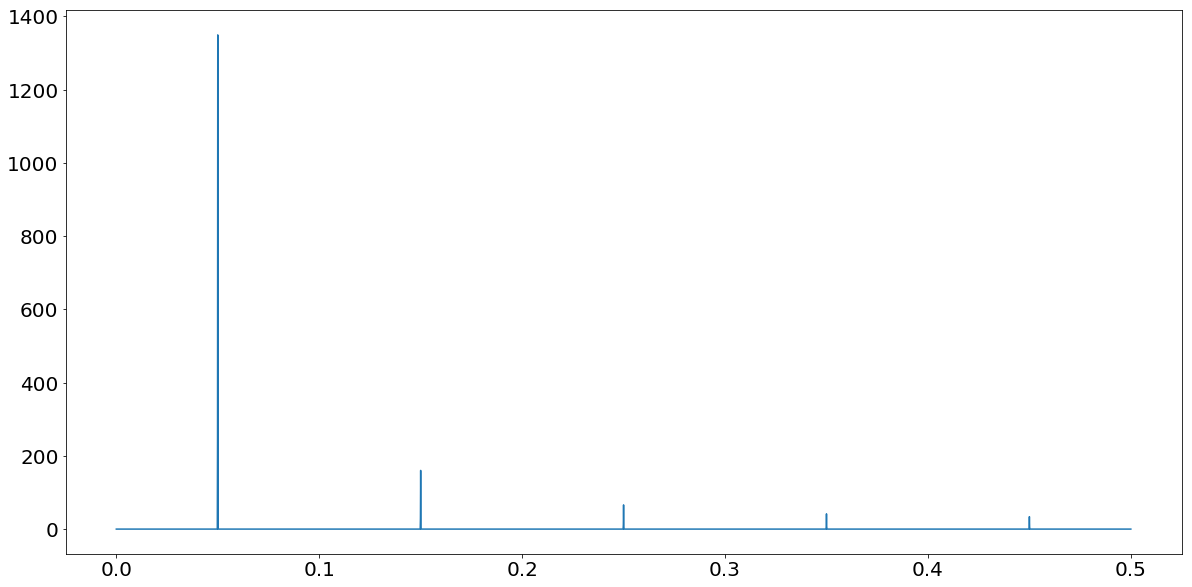

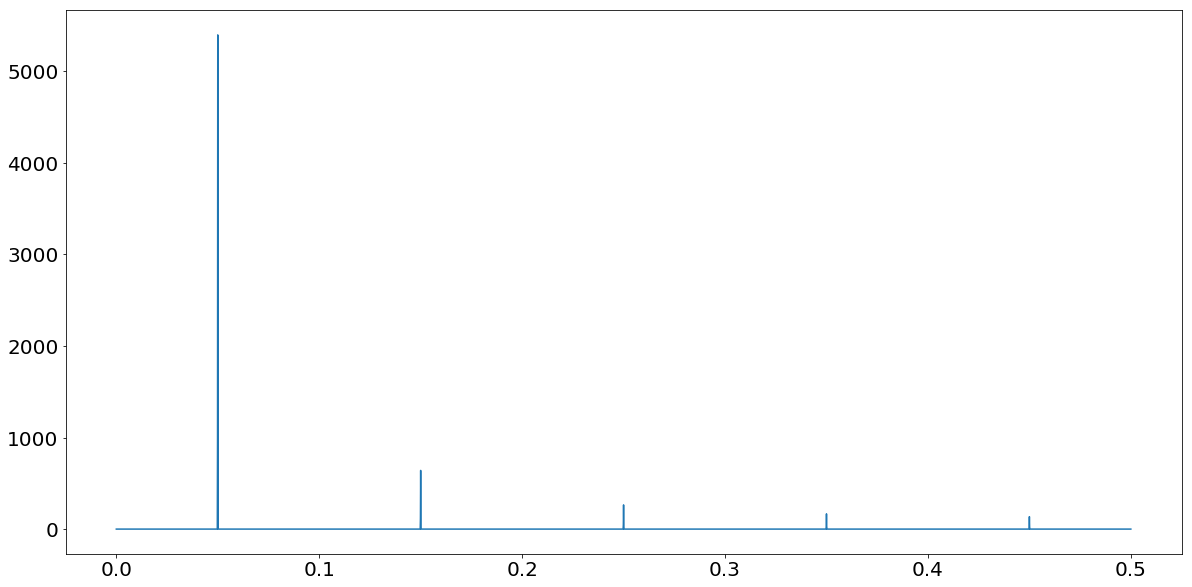

In [81]:
periodic_fn = np.array([(i // 10) % 2 for i in range(10000)])
f, psd = get_psd_table(table=periodic_fn.reshape(10000, 1), transient_cutoff=1000, normalize=False)


# For calculating integral.. 
np.repeat(np.diff(f)[0], repeats=psd.size)

# Integrates to var... 
np.dot(psd.T, np.repeat(np.diff(f)[0], repeats=psd.size))
# For the periodic signal..
plt.plot(f, psd)
plt.show()


f, psd = get_psd_table(table=periodic_fn.reshape(10000, 1), transient_cutoff=1000, normalize=True)

plt.plot(f, psd)
plt.show()



In [58]:
# For totally random sequences and for periodic sequences, the variance is 0

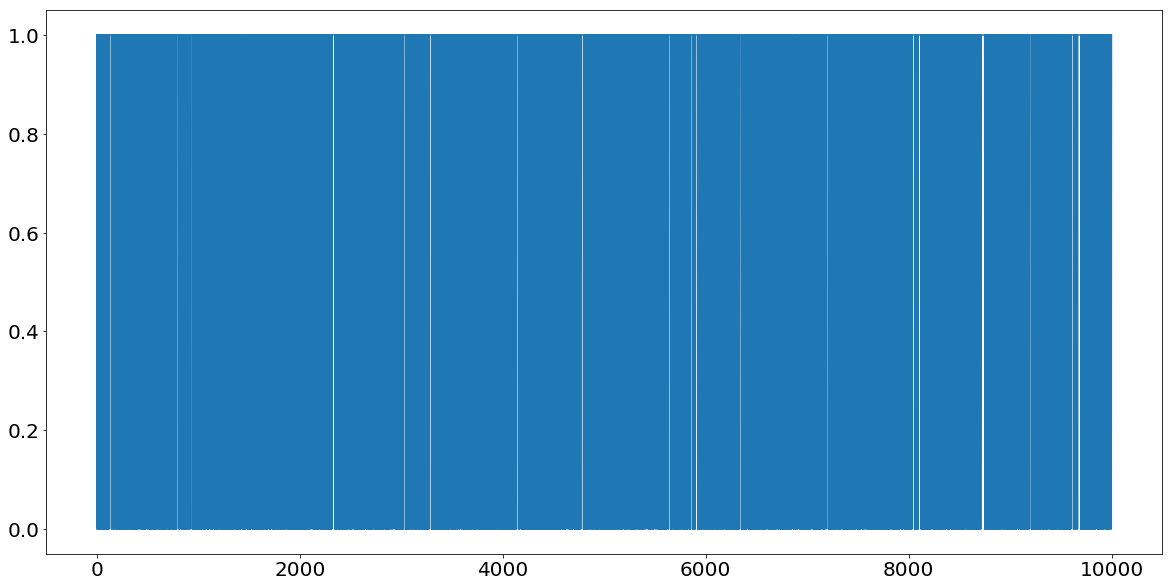

In [3]:
# How about for other types of randomness? 

rnd_seq = np.random.choice([0,1], replace=True, p=[0.2, 1 - 0.2], size=10000)

plt.plot(rnd_seq)
plt.show()

In [4]:
np.var(rnd_seq)

# Theoretically if it's not random but has some switching... then it's going to be lower variance..
# By making this choice of normalization, we likely negate the effect of unequal switches? 


0.15752318999999998

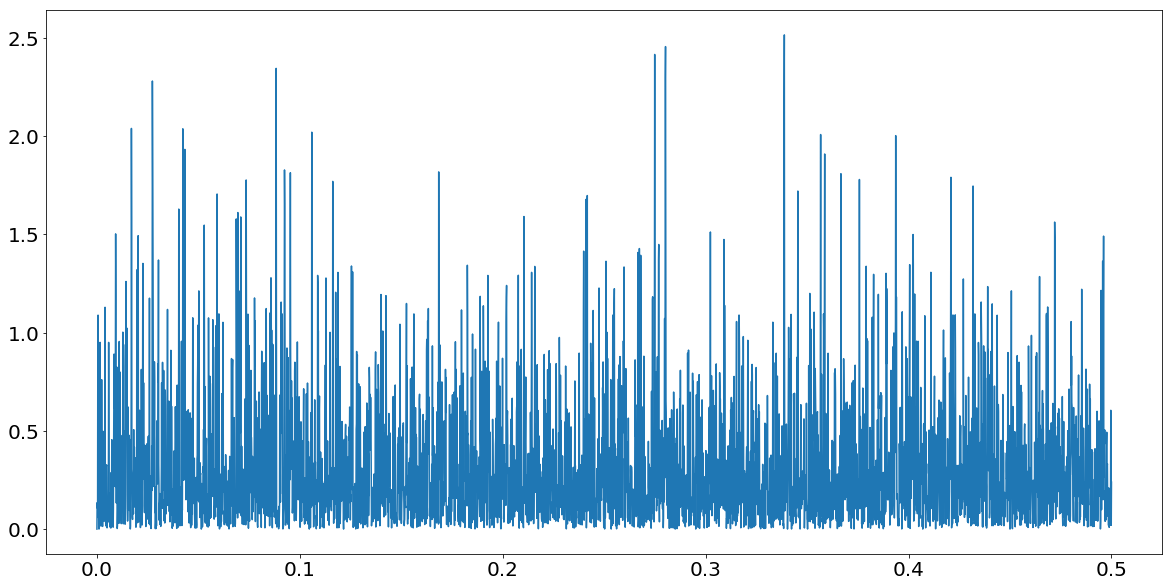

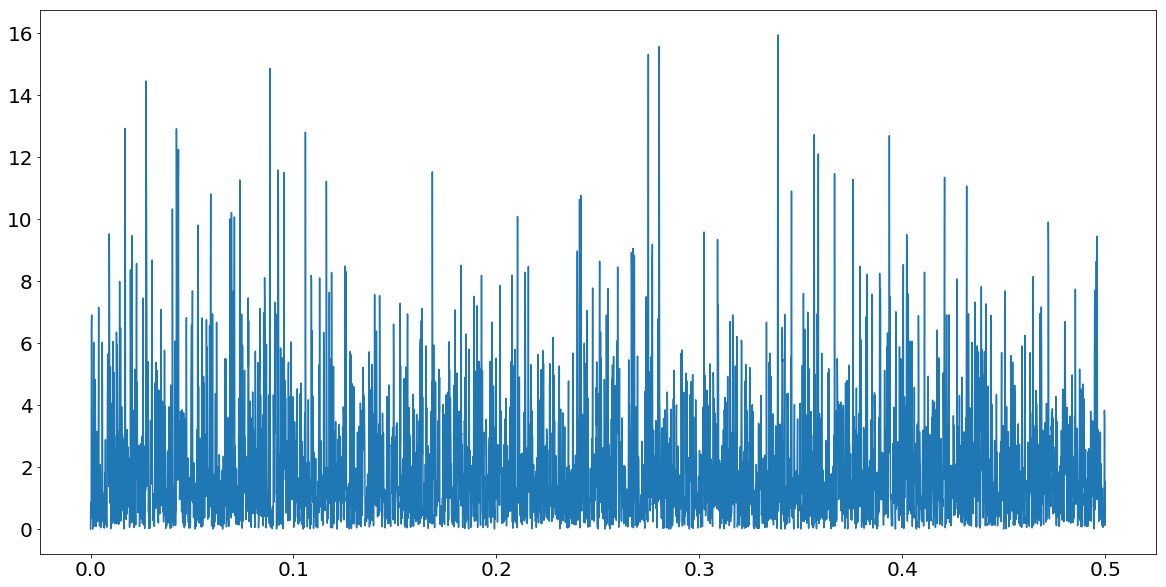

In [6]:
f, psd = get_psd_table(table=rnd_seq.reshape(10000, 1), transient_cutoff=1000, normalize=False)
plt.plot(f,psd)
# plt.ylim([0.1,10**-2])


plt.show()

f, psd = get_psd_table(table=rnd_seq.reshape(10000, 1), transient_cutoff=1000, normalize=True)
plt.plot(f,psd)
# plt.ylim([0.1,10])
plt.show()





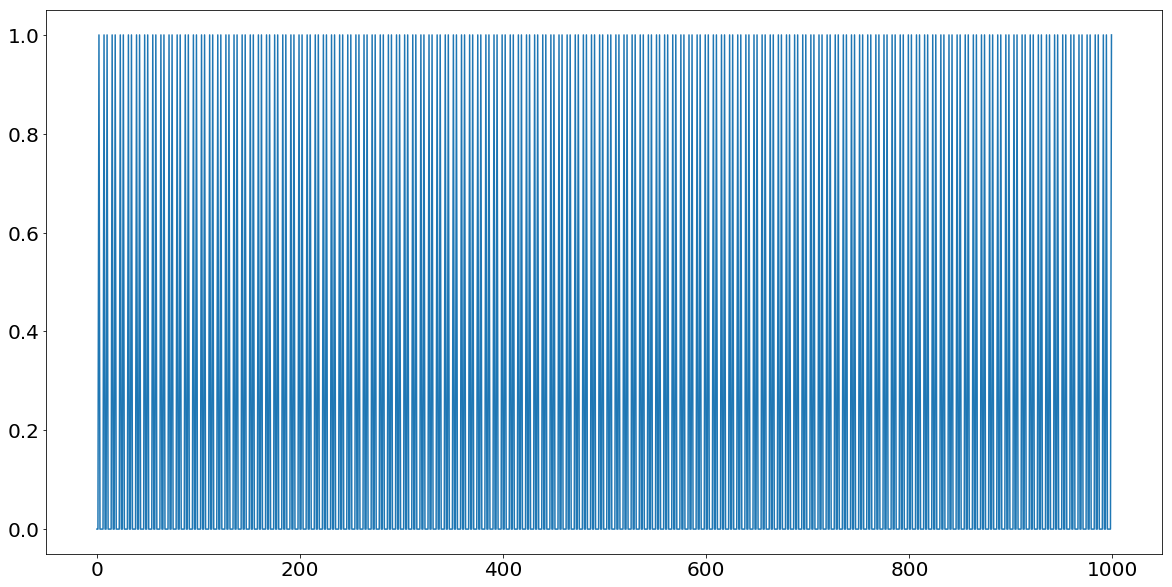

In [9]:
rnd_pulse = np.array([0,0,1,0,0,0,0,1] * 1000 )
plt.plot(rnd_pulse[0:1000])
plt.show()

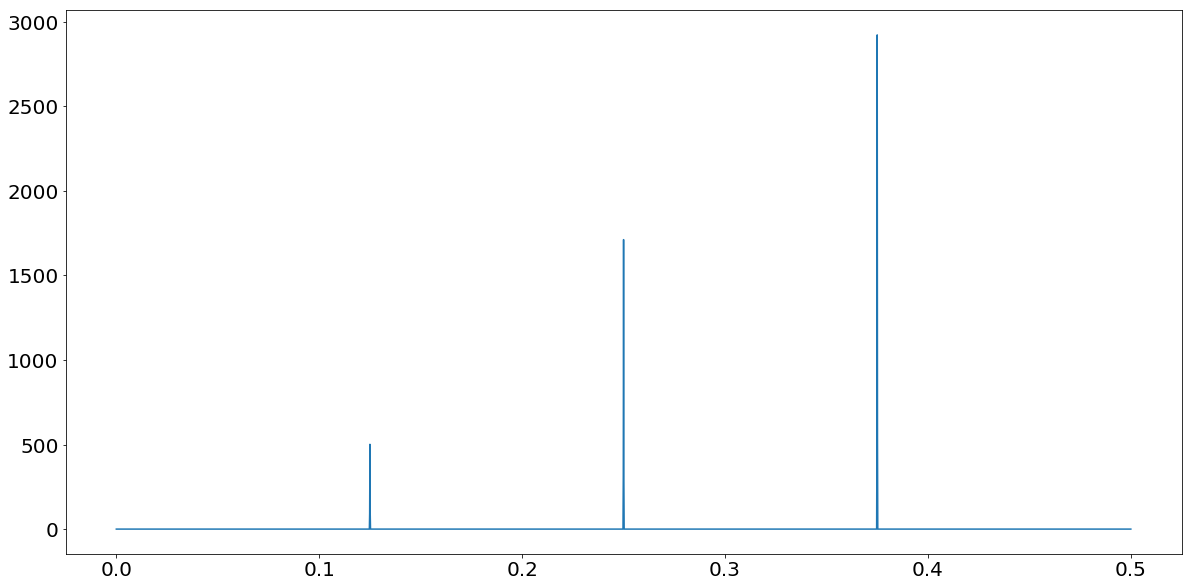

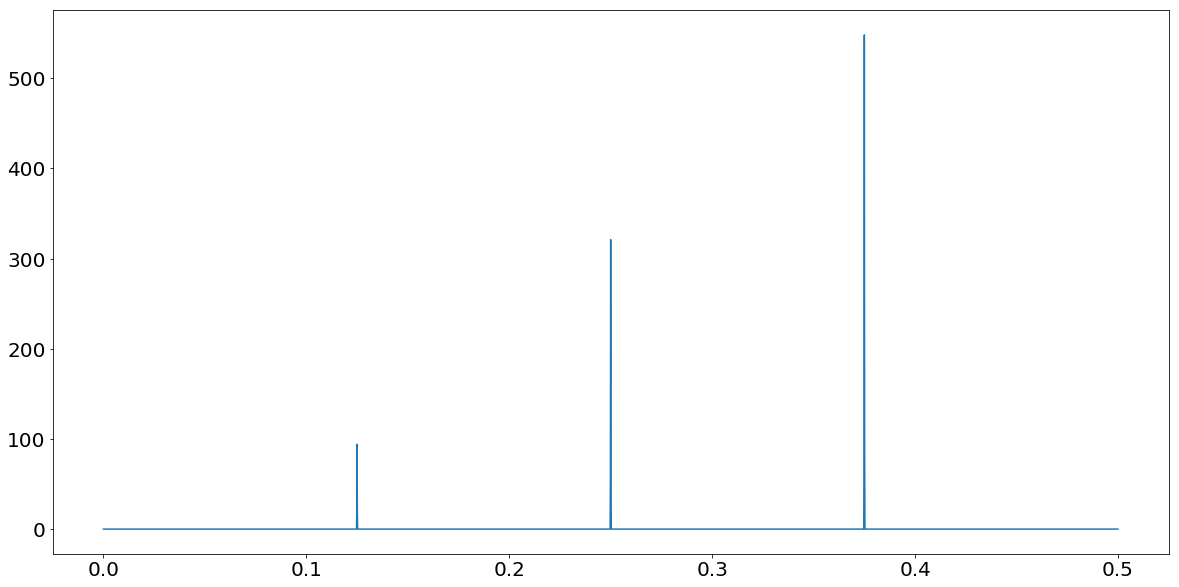

In [11]:
np.var(rnd_pulse)

f, psd = get_psd_table(table=rnd_pulse.reshape(rnd_pulse.size, 1), transient_cutoff=1000, normalize=True)
plt.plot(f,psd)
plt.show()

f, psd = get_psd_table(table=rnd_pulse.reshape(rnd_pulse.size, 1), transient_cutoff=1000, normalize=False)
plt.plot(f,psd)
plt.show()



In [ ]:
# normalize = false seems to force us to have better signals??? 

## What happens when we oscillate the non-hub node? 
Generate statistics about connectivity of the network

In [283]:
gammas = np.linspace(1.7, 3.5, 15)
n = 1000 
test_graphs = 10
connectivities = []
for gamma in gammas:
    store = np.zeros(n)
    for j in range(test_graphs): 
        test_graph = SFGraph(n, gamma)
        store += np.sort(test_graph.out_degree()) / test_graphs
    connectivities.append(store)

In [285]:

for index, c in enumerate(connectivities): 
    out_degs = np.flip(np.sort(c), axis=0)
    print(f"GAMMA: {gammas[index]}")
    print(out_degs[0:20])
    print("\n\n")




GAMMA: 1.7
[803.2 634.6 545.7 468.2 400.1 349.2 304.4 260.7 247.9 219.6 202.4 187.9
 168.4 159.3 146.4 140.6 130.9 119.9 117.2 111.1]



GAMMA: 1.8285714285714285
[676.1 513.6 381.8 310.2 261.2 233.3 197.  149.2 132.4 120.2 112.2 105.1
  99.2  86.7  82.4  77.6  72.4  67.3  62.6  60.7]



GAMMA: 1.957142857142857
[517.  320.4 210.8 146.9 116.6  99.5  82.9  72.9  66.6  61.1  55.6  52.5
  48.1  44.9  41.9  39.4  36.4  34.7  33.2  31.8]



GAMMA: 2.085714285714286
[306.6 230.9 127.5  81.8  73.6  60.3  55.1  50.   45.2  42.9  41.3  38.5
  34.7  31.9  29.8  28.2  25.9  24.8  23.   22.3]



GAMMA: 2.2142857142857144
[344.9 106.1  84.9  65.4  51.2  42.8  37.2  32.2  29.6  27.2  25.1  24.
  22.5  21.3  19.1  17.8  17.1  16.3  15.5  15. ]



GAMMA: 2.342857142857143
[196.5  97.   56.5  39.7  31.1  28.6  25.   23.3  21.4  19.5  16.6  15.8
  14.8  13.8  13.   12.3  11.9  11.5  11.1  10.7]



GAMMA: 2.4714285714285715
[169.6  62.2  46.8  38.8  29.3  24.9  21.6  18.9  16.8  16.2  15.1  13.4
  12.8  